# README
------

- 작성자 : 이혁희

이전 Chapter에서 작성한 모델을 기반으로 1. Augmentation, 2. Regularization하여 결과를 비교해 보고 3. ResNet18을 이용하여 다시 학습하여 보았습니다.


## 1. Augmentation
- epochs = 20
- batch_size = 32

### 1.1 데이터 좌우 반전
- 이미지에 좌우 반전한 데이터를 학습 데이터에 추가하였습니다.
```
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label
```

### 1.2 시각화
데이터의 반전이 제대로 처리 되었습니다.

Chap 5에서 시각화를 했을 때 장기의 하얀부분이 왼쪽으로 치우쳐 있는데 위의 이미지는 외쪽과 오른쪽으로 치우친 것이 섞여 있는 것을 볼 수 있습니다.

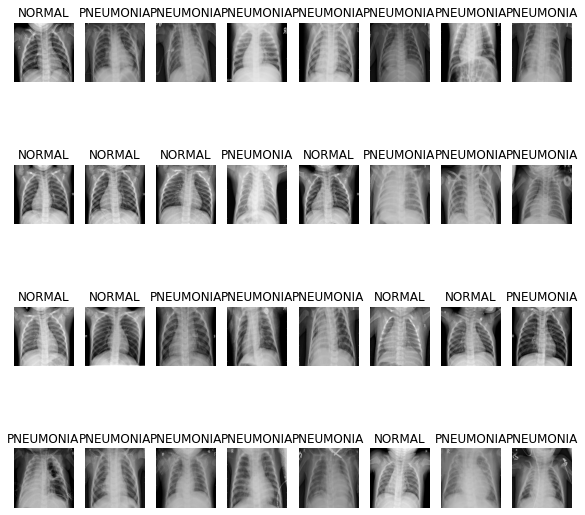

### 1.3 학습 및 결과 확인

- 모델 수렴 여부 확인
    - 잘 수렴합니다.

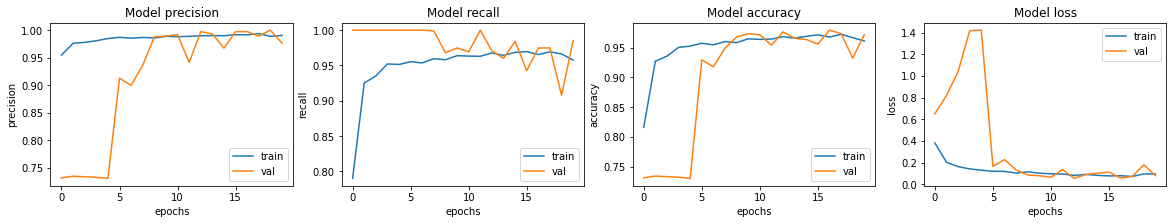

- Test Metric
```
recall: 1.0000
Loss: 1.0945968627929688,
Accuracy: 0.7339743375778198,
Precision: 0.701438844203949,
Recall: 1.0
```

- 데이터 반전 Augmentation하기 전 결과와 비교
    - Validation metric은 원 모델의 결과보다 낫습니다.
    - 테스트 metric의 결과는 원 모델보다 못합니다.
        - Accuracy = 84.6:73.4
        - Precision = 81.0 : 70.1
        - Recall = 98.5 : 1.0
    - 이것은 training 데이터와 validataion 데이터에 똑 같이 반전을 적용했기 때문인 것 같습니다.
    - Test 데이터에는 반전을 적용하지 않았으므로, Test 데이터에 대한 예측 능력이 떨어지는 것 같습니다.
    - Precision은 떨어지고 Recall은 1까지 올라갑니다. 

## 2. Regularization

### 2.1 데이터 준비
데이터 좌우 반전을 하지 않았습니다.(반전을 한 것이 test accuracy를 떨어 뜨렸다 판단)

### 2.2 모델 정의
- convolution과 dense 레이어에 L2 regularization 적용하였습니다.(l2_factor = 0.001)
```
kernel_regularizer=regularizers.l2(l2_factor)
```

### 2.3 결과 확인
- 모델 수렴 여부 확인
    - validation metric들이 튀는 현상을 보입니다.
    - learning_rate를 0.0003으로 조절했는데도 그렇습니다.
    - 다음에 더 줄여 볼 예정
    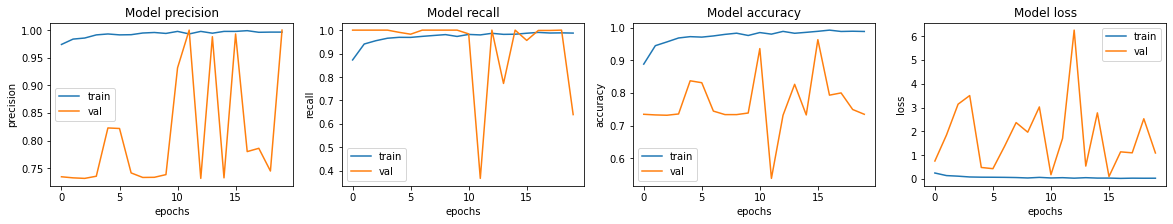
    
- Test metric
```
recall: 0.7718
Loss: 0.5613988637924194,
Accuracy: 0.8333333134651184,
Precision: 0.952531635761261,
Recall: 0.771794855594635
```

- 비교
    - Accuracy는 원래 모델과 비슷합니다.
    - Precison이 가장 높고 Recall은 낮습니다.


## 3. ResNet 16 구현
### 3.1 모델 정의
- 데이터는 [Regularization]에 정의한 대로 사용하였습니다.

- 모델의 모양은 LMS에서 제시한 대로 했고 filter 수와 channel size를 다음과 같이 조절하였습니다.

```
Conv2D(32, 7)
conv_block(32, 3)
conv_block(64, 3)
conv_block(128, 3)
conv_block(256, 3)
dense_block(512)
```

- resnet_block에서 skip_connection과 convolution을 통과한 feature map의 channel 수가 달라서 맞추는 작업이 필요하였습니다.
```
x_skip = layers.Conv2D(filters, (1, 1), padding = 'same')(x_skip)
```

- learning rate = 0.0003

### 3.2 결과 확인

- 모델 수렴 여부 확인
    - validation metric들이 튀는 현상을 보입니다.
    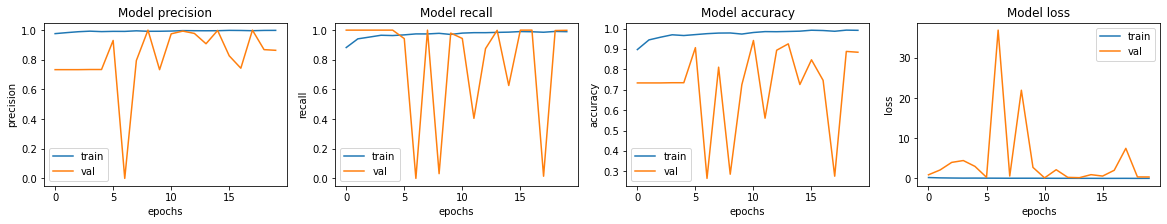
- Test metric
```
recall: 1.0000
Loss: 1.8792489767074585,
Accuracy: 0.692307710647583,
Precision: 0.6701030731201172,
Recall: 1.0
```

## 4. 회고

### 잘한점
- 루브릭 기준에 맞게 진행했다.
- 질문을 많이 했다.

### 문제점
- validation metric history가 계속 튄다. 나만 그런가?

### 배운점
- ResNet의 skip connection하는 방법을 정확히 알게 되었다.


## 5. 참고 링크
https://github.com/alinarw/ResNet/blob/master/ResNet.ipynb


-------

# 6-1. 프로젝트 : 폐렴 진단기 성능개선

In [1]:
import tensorflow

print(tensorflow.__version__)

2.6.0


In [2]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

# [Augmentation]

## 데이터 준비(Chap 5 내용을 반복)

In [4]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 8
EPOCHS = 20

In [5]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [6]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [8]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


In [9]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [10]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [11]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [12]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [13]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [14]:
for image, label in train_ds.take(2):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False
Image shape:  (180, 180, 3)
Label:  True


In [15]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


이미지에 좌우 반전한 데이터를 학습 데이터에 추가하였습니다.


In [14]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

## Step3. 데이터 시각화
- 

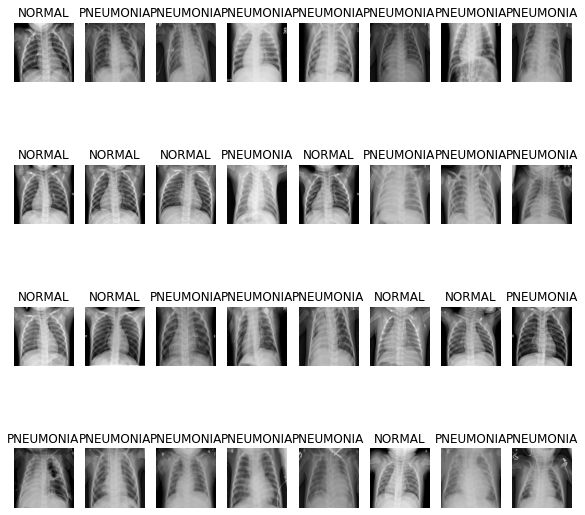

In [15]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

데이터의 반전이 제대로 처리 되었습니다.
- Chap 5에서 시각화를 했을 때 장기의 하얀부분이 왼쪽으로 치우쳐 있는데 위의 이미지는 외쪽과 오른쪽으로 치우친 것이 섞여 있는 것을 볼 수 있습니다.

## Step 4. 훈련을 위한 데이터 준비

In [16]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


## Step 5. 모델 학습

In [18]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/20
130/130 [==============================] - 107s 398ms/step - loss: 0.3819 - accuracy: 0.8161 - precision: 0.9547 - recall: 0.7902 - val_loss: 0.6513 - val_accuracy: 0.7314 - val_precision: 0.7314 - val_recall: 1.0000
Epoch 2/20
130/130 [==============================] - 52s 401ms/step - loss: 0.2039 - accuracy: 0.9274 - precision: 0.9762 - recall: 0.9251 - val_loss: 0.8190 - val_accuracy: 0.7344 - val_precision: 0.7344 - val_recall: 1.0000
Epoch 3/20
130/130 [==============================] - 52s 404ms/step - loss: 0.1639 - accuracy: 0.9358 - precision: 0.9777 - recall: 0.9351 - val_loss: 1.0396 - val_accuracy: 0.7334 - val_precision: 0.7334 - val_recall: 1.0000
Epoch 4/20
130/130 [==============================] - 54s 418ms/step - loss: 0.1429 - accuracy: 0.9505 - precision: 0.9807 - recall: 0.9522 - val_loss: 1.4166 - val_accuracy: 0.7324 - val_precision: 0.7324 - val_recall: 1.0000
Epoch 5/20
130/130 [==============================] - 56s 430ms/step - loss: 0.1305 - accur

## Step 6. 결과 확인

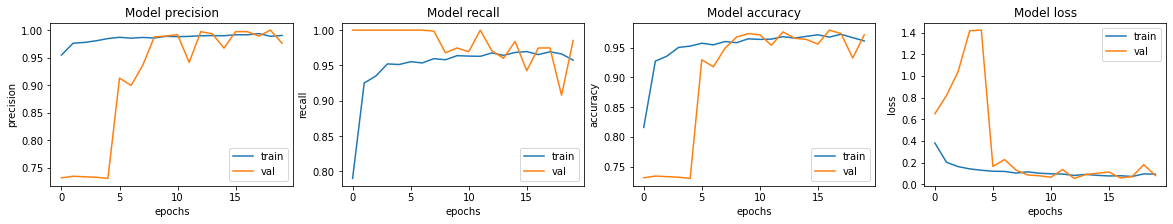

In [19]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [20]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

20/20 [==============================] - 5s 250ms/step - loss: 1.0946 - accuracy: 0.7340 - precision: 0.7014 - recall: 1.0000
Loss: 1.0945968627929688,
Accuracy: 0.7339743375778198,
Precision: 0.701438844203949,
Recall: 1.0


# [Regularization]

### Step 1. 데이터 준비
- 데이터 좌우 반전을 하지 않음.(반전을 한 것이 test accuracy를 떨어 뜨렸다 판단)

In [7]:
BATCH_SIZE = 8

# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))


COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")


train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")


# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)


# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)


test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)


def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)


4185
1047
Normal images count in training set: 1070
Pneumonia images count in training set: 3115
Training images count: 4185
Validating images count: 1047
624


## Step 2. 모델 정의
- convolution과 dense 레이어에 L2 regularization 적용(l2_factor = 0.001)
```
kernel_regularizer=regularizers.l2(l2_factor)
```


In [28]:
from tensorflow.keras import regularizers

def conv_block(filters, l2_factor):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same',
                                       kernel_regularizer=regularizers.l2(l2_factor)),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same',
                                       kernel_regularizer=regularizers.l2(l2_factor)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

def dense_block(units, l2_factor):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu', 
                             kernel_regularizer=regularizers.l2(l2_factor)),
        tf.keras.layers.BatchNormalization(),
        #tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

def build_model():
    l2_factor = 0.001
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32, l2_factor),
        conv_block(64, l2_factor),
        
        conv_block(128, l2_factor),
        #f.keras.layers.Dropout(0.2),
        
        conv_block(256, l2_factor),
        #f.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, l2_factor),
        dense_block(128, l2_factor),
        dense_block(64, l2_factor),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


## Step3. 학습

In [87]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0003)

    model.compile(
        optimizer = optimizer,
        loss='binary_crossentropy',
        metrics=METRICS
    )

with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/20
130/130 [==============================] - 65s 422ms/step - loss: 0.2476 - accuracy: 0.8880 - precision: 0.9741 - recall: 0.8729 - val_loss: 0.7509 - val_accuracy: 0.7344 - val_precision: 0.7344 - val_recall: 1.0000
Epoch 2/20
130/130 [==============================] - 53s 413ms/step - loss: 0.1394 - accuracy: 0.9445 - precision: 0.9838 - recall: 0.9408 - val_loss: 1.8436 - val_accuracy: 0.7324 - val_precision: 0.7324 - val_recall: 1.0000
Epoch 3/20
130/130 [==============================] - 53s 410ms/step - loss: 0.1147 - accuracy: 0.9560 - precision: 0.9857 - recall: 0.9549 - val_loss: 3.1401 - val_accuracy: 0.7314 - val_precision: 0.7314 - val_recall: 1.0000
Epoch 4/20
130/130 [==============================] - 53s 411ms/step - loss: 0.0811 - accuracy: 0.9680 - precision: 0.9914 - recall: 0.9654 - val_loss: 3.5024 - val_accuracy: 0.7354 - val_precision: 0.7354 - val_recall: 1.0000
Epoch 5/20
130/130 [==============================] - 55s 423ms/step - loss: 0.0720 - accura

## Step 4. 결과 확인
### 모델 수렴 여부 확인
- validation metric들이 튀는 현상을 보입니다.
- learning_rate를 0.0003으로 조절했는데도 그렇습니다.
- 다음에 더 줄여 볼 예정

### Test metric
```
recall: 0.7718
Loss: 0.5613988637924194,
Accuracy: 0.8333333134651184,
Precision: 0.952531635761261,
Recall: 0.771794855594635
```


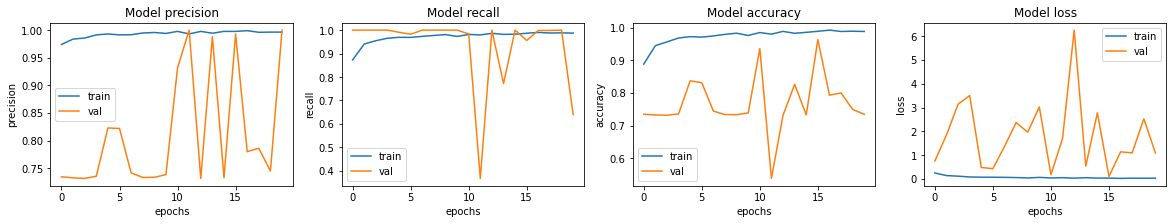

In [88]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [89]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

20/20 [==============================] - 5s 230ms/step - loss: 0.5614 - accuracy: 0.8333 - precision: 0.9525 - recall: 0.7718
Loss: 0.5613988637924194,
Accuracy: 0.8333333134651184,
Precision: 0.952531635761261,
Recall: 0.771794855594635


# [ResNet-18 구현]

## Step 1. 모델 정의
- 데이터는 [Regularization]에 정의한 대로 사용하였습니다.
- 모델의 모양은 LMS에서 제시한 대로 했고 filter 수와 channel size를 다음과 같이 조절하였습니다.
> - Conv2D(32, 7)
> - conv_block(32, 3)
> - conv_block(64, 3)
> - conv_block(128, 3)
> - conv_block(256, 3)
> - dense_block(512)

- resnet_block에서 skip_connection과 convolution을 통과한 feature map의 channel 수가 달라서 맞추는 작업이 필요하였습니다.
```
 x_skip = layers.Conv2D(filters, (1, 1), padding = 'same')(x_skip)
```
- learning rate = 0.0003

In [8]:
from tensorflow import keras
from tensorflow.keras import layers


def resnet_block(x, filters, kernel_size):
    x_skip = x
    
    x = layers.SeparableConv2D(filters, kernel_size, padding = 'same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    x = layers.SeparableConv2D(filters, kernel_size, padding = 'same')(x)
    x = layers.BatchNormalization()(x)
    
    # channel 수를 맞추기 위해서 1x1 filter를 filters만큼 해서  convolution한다.
    x_skip = layers.Conv2D(filters, (1, 1), padding = 'same')(x_skip)
    
    x = layers.Add()([x, x_skip])
    x = layers.Activation('relu')(x)
    
    return x

def dense_block(x, units):
    x = layers.Dense(units)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    return x


In [9]:
def build_model():
    input_layer = layers.Input(shape = (180, 180, 3))
    conv1 = layers.Conv2D(64, 7, strides = 2, padding = "same")(input_layer)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.MaxPooling2D(pool_size = 3, strides = 2, padding = "same")(conv1)
    
    conv2_x = resnet_block(conv1, 64, 3)
    conv3_x = resnet_block(conv2_x, 128, 3)
    conv4_x = resnet_block(conv3_x, 256, 3)
    conv5_x = resnet_block(conv4_x, 512, 3)
    
    avg_pool = layers.GlobalAveragePooling2D()(conv5_x) #pool_size = (7, 7))(conv5_x)
    x = layers.Flatten()(avg_pool)
    x = dense_block(x, 1000)
    #x = dense_block(x, 1000)
    out_layer = layers.Dense(1, activation = 'sigmoid')(x)

    model = keras.Model(inputs = [input_layer], outputs = [out_layer])
    return model

# def build_model():
#     input_layer = layers.Input(shape = (180, 180, 3))
#     conv1 = layers.Conv2D(32, 7, strides = 2, padding = "same")(input_layer)
#     conv1 = layers.BatchNormalization()(conv1)
#     conv1 = layers.MaxPooling2D(pool_size = 3, strides = 2, padding = "same")(conv1)
    
#     conv2_x = resnet_block(conv1, 32, 3)
#     conv3_x = resnet_block(conv2_x, 64, 3)
#     conv4_x = resnet_block(conv3_x, 128, 3)
#     conv5_x = resnet_block(conv4_x, 256, 3)
    
#     avg_pool = layers.GlobalAveragePooling2D()(conv5_x) #pool_size = (7, 7))(conv5_x)
#     x = layers.Flatten()(avg_pool)
#     x = dense_block(x, 512)
#     #x = dense_block(x, 1000)
#     out_layer = layers.Dense(1, activation = 'sigmoid')(x)

#     model = keras.Model(inputs = [input_layer], outputs = [out_layer])
#     return model

In [10]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

    model.compile(
        optimizer = optimizer, 
        loss = 'binary_crossentropy',
        metrics=METRICS
    )

model.summary()

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 90, 90, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 90, 90, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 45, 45, 64)   0           batch_normalization[0][0]        
___________________________________________

## Step 2. 학습

In [11]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/20
523/523 [==============================] - 72s 109ms/step - loss: 0.2886 - accuracy: 0.8760 - precision: 0.9626 - recall: 0.8671 - val_loss: 3.0263 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 2/20
523/523 [==============================] - 56s 107ms/step - loss: 0.1968 - accuracy: 0.9226 - precision: 0.9784 - recall: 0.9162 - val_loss: 1.6726 - val_accuracy: 0.5760 - val_precision: 0.9763 - val_recall: 0.4318
Epoch 3/20
523/523 [==============================] - 56s 108ms/step - loss: 0.1491 - accuracy: 0.9405 - precision: 0.9864 - recall: 0.9329 - val_loss: 0.6500 - val_accuracy: 0.7048 - val_precision: 0.7492 - val_recall: 0.8992
Epoch 4/20
523/523 [==============================] - 56s 107ms/step - loss: 0.1457 - accuracy: 0.9407 - precision: 0.9815 - recall: 0.9380 - val_loss: 1.3337 - val_accuracy: 0.6500 - val_precision: 0.9950 - val_recall: 0.5256
Epoch 5/20
523/523 [==============================] - 56s 107ms/step - loss: 0.1419 - accura

## Step 4. 결과 확인

### 모델 수렴 여부 확인
- validation metric들이 튀는 현상을 보입니다.

### Test metric
```
recall: 0.7718
Loss: 0.5613988637924194,
Accuracy: 0.8333333134651184,
Precision: 0.952531635761261,
Recall: 0.771794855594635
```

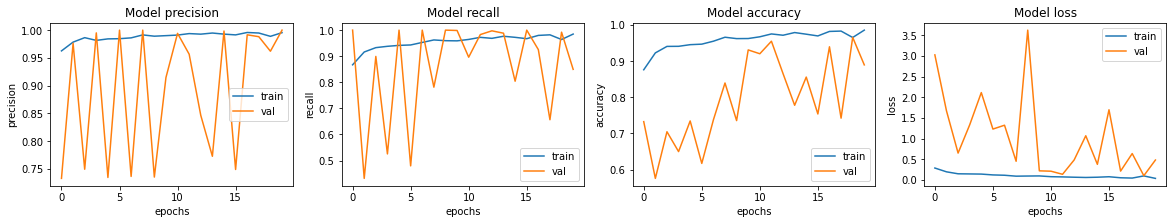

In [12]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [14]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

78/78 [==============================] - 5s 62ms/step - loss: 0.3974 - accuracy: 0.8846 - precision: 0.9297 - recall: 0.8821
Loss: 0.3974275588989258,
Accuracy: 0.8846153616905212,
Precision: 0.929729700088501,
Recall: 0.8820512890815735


## 참고 - 노드에 주어진 파라미터대로 돌린 결과
- learning rate = 0.001이라서 이런가?

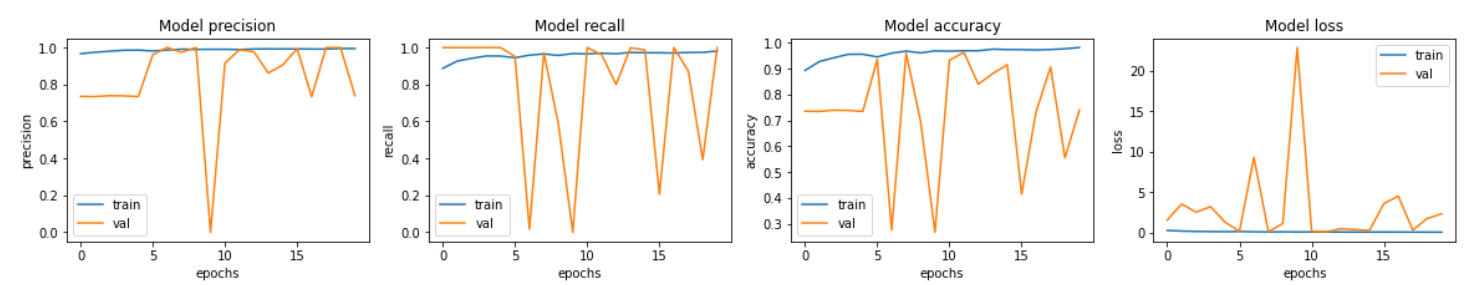

```
20/20 [==============================] - 5s 253ms/step - loss: 5.2978 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000
Loss: 5.297787189483643,
Accuracy: 0.625,
Precision: 0.625,
Recall: 1.0
```

https://github.com/alinarw/ResNet/blob/master/ResNet.ipynb